# (Efficient) Spherical Harmonic Transform

## Preliminaries

### Spherical harmonics transform

The truncated series expansion of a function $f$ defined on the surface of a sphere can be written as

$$
f(\theta, \lambda) = \sum_{m=-M}^{M} \exp(im\lambda) \sum_{n=|m|}^{M} F_n^m \bar{P}_n^m (\cos \theta),
$$

where $\theta$ is the colatitude, $\lambda$ the longitude, $\bar{P}_n^m$ the normalized, associated Legendre polynomials and $F_n^m$, the expansion coefficient associated to the mode $(m,n)$.

A direct spherical harmonic transform can be accomplished by a Fourier transform

$$
F^m(\theta) = \frac{1}{2 \pi} \int_{0}^{2\pi} f(\theta, \lambda) \exp(-im\lambda) \; \mathrm{d}\lambda
$$

in longitude and a Legendre transform

$$
F_n^m = \frac{1}{2} \int_{-1}^1 F^m(\theta) \bar{P}_n^m(\cos \theta) \; \mathrm{d} \cos \theta
$$

in latitude.

## Usage

### Preparation

Let us begin by loading some libraries that we will be needing:

In [16]:
import torch
import torch.nn as nn
import torch.fft as fft
import numpy as np
import matplotlib.pyplot as plt

import sys
sys.path.append("../")

cmap = 'turbo'

We should also load the `torch-sht`:

In [17]:
from torch_harmonics import *

If a GPU is available we want to use it:

In [18]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

### Test data

Let us load some test-data in 2D for testing. We use the MOLA digital elevation map of MARS, courtesy of NASA:

In [19]:
!wget https://astropedia.astrogeology.usgs.gov/download/Mars/GlobalSurveyor/MOLA/thumbs/Mars_MGS_MOLA_DEM_mosaic_global_1024.jpg -O ./data/mola_topo.jpg

/home/bbonev/.zshenv:export:2: not valid in this context: :/usr/local/cuda-11.7/lib64
--2025-01-09 00:30:29--  https://astropedia.astrogeology.usgs.gov/download/Mars/GlobalSurveyor/MOLA/thumbs/Mars_MGS_MOLA_DEM_mosaic_global_1024.jpg
Resolving astropedia.astrogeology.usgs.gov (astropedia.astrogeology.usgs.gov)... 137.227.239.81, 2001:49c8:c000:122d::81
Connecting to astropedia.astrogeology.usgs.gov (astropedia.astrogeology.usgs.gov)|137.227.239.81|:443... 

connected.
HTTP request sent, awaiting response... 200 
Length: 55192 (54K) [image/jpeg]
Saving to: ‘./data/mola_topo.jpg’

./data/mola_topo.jp 100%[===================>]  53.90K   169KB/s    in 0.3s    

2025-01-09 00:30:50 (169 KB/s) - ‘./data/mola_topo.jpg’ saved [55192/55192]



Let us load and visualize the data:

In [20]:
import imageio.v3 as iio

img = iio.imread('./data/mola_topo.jpg')
#convert to grayscale
data = np.dot(img[...,:3]/255, [0.299, 0.587, 0.114])
# interpolate onto 512x1024 grid:
data = nn.functional.interpolate(torch.from_numpy(data).unsqueeze(0).unsqueeze(0), size=(512,1024)).squeeze()

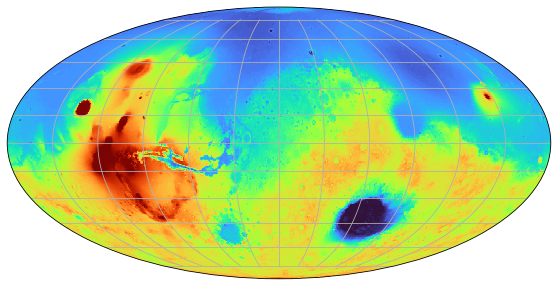

In [21]:
n_theta = data.shape[0]
n_lambda = data.shape[1]
lon = np.linspace(-np.pi, np.pi, n_lambda)
lat = np.linspace(np.pi/2., -np.pi/2., n_theta)
Lon, Lat = np.meshgrid(lon, lat)

fig = plt.figure(figsize=(10, 5))
ax = fig.add_subplot(1, 1, 1, projection='mollweide')
ax.pcolormesh(Lon, Lat, data, cmap=cmap)
# ax.set_title("Elevation map of mars")
ax.grid(True)
ax.set_xticklabels([])
ax.set_yticklabels([])
plt.show()

We want the data on the GPU. Moreover, `torch_harmonics` expects the last two dimensions to be the spatial dimensions. To this end, we permute the data:

In [22]:
signal = data.to(device)

### Spherical Harmonic Transform:

To allow for composability, `torch_harmonics` provides it's transform in the form of PyTorch NN modules. As such we begin by initializing them:

In [23]:
sht = RealSHT(n_theta, n_lambda, grid="equiangular").to(device)
isht = InverseRealSHT(n_theta, n_lambda, grid="equiangular").to(device)

In [24]:
coeffs = sht(signal)

Let us plot the logarithm of the absolute coefficients:

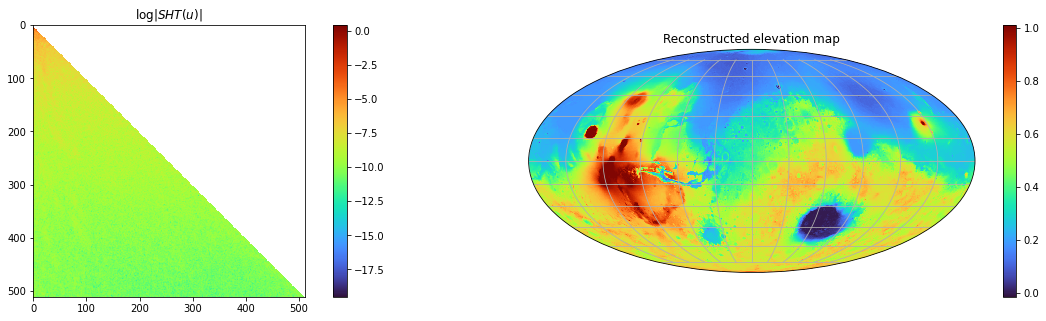

In [25]:
fig = plt.figure(figsize=(22, 5))
ax = fig.add_subplot(1, 2, 1)
plt.imshow(coeffs.abs().log().cpu(), cmap=cmap)
plt.title("$\log | SHT(u) |$")
plt.colorbar()

ax = fig.add_subplot(1, 2, 2, projection='mollweide')
plt.pcolormesh(Lon, Lat, isht(coeffs).cpu(), cmap=cmap)
ax.set_title("Reconstructed elevation map")
ax.grid(True)
ax.set_xticklabels([])
ax.set_yticklabels([])
plt.colorbar()
plt.show()

We can transform the the solution back and plot the error:

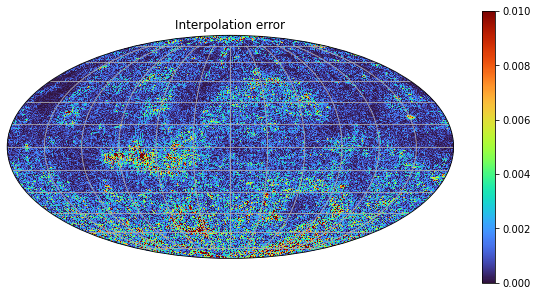

In [26]:
fig = plt.figure(figsize=(10, 5))
ax = fig.add_subplot(1, 1, 1, projection='mollweide')
img = ax.pcolormesh(Lon, Lat, (isht(coeffs).cpu() - data).abs(), cmap=cmap, vmin=0, vmax=0.01)
ax.set_title("Interpolation error")
ax.grid(True)
ax.set_xticklabels([])
ax.set_yticklabels([])
plt.colorbar(img, ax=ax)
plt.show()

### Differentiability

`torch_harmonics` is differentiable, so let's use this functionality. We can perform a simple fit of spectral coefficients by using a simple model which will use 100 modes to approximate our original model:

In [27]:
class SpectralModel(nn.Module):
    def __init__(self, n_modes, out_dims):
        super().__init__()
        self.coeffs = nn.Parameter(torch.randn(n_modes, n_modes+1, dtype=torch.complex128))
        self.isht = InverseRealSHT(out_dims[0], out_dims[1], lmax=n_modes, mmax=n_modes+1, grid="equiangular").to(device)

    def forward(self):
        return self.isht(self.coeffs)

sh_model = SpectralModel(120, (n_theta, n_lambda)).to(device)
sh_model

SpectralModel(
  (isht): InverseRealSHT(
    nlat=512, nlon=1024,
     lmax=120, mmax=121,
     grid=equiangular, csphase=True
  )
)

and now, let us train the model

In [28]:
optimizer = torch.optim.Adam(sh_model.parameters(), lr = 5e-2)

for iter in range(500):

    loss = (sh_model() - signal).pow(2).mean()

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    if iter % 10 == 0:
        print(f'iteration: {iter} loss: {loss.item()}')

iteration: 0 loss: 1110.5501509434434
iteration: 10 loss: 307.2719964223394
iteration: 20 loss: 94.85549328211366
iteration: 30 loss: 33.84012136397667
iteration: 40 loss: 13.27256860537048
iteration: 50 loss: 5.330296084257617
iteration: 60 loss: 2.22780331377308
iteration: 70 loss: 0.9787531762231616
iteration: 80 loss: 0.4689970429107282
iteration: 90 loss: 0.23740534161941174
iteration: 100 loss: 0.12912743071119842
iteration: 110 loss: 0.07353356327159222
iteration: 120 loss: 0.04269109352645242
iteration: 130 loss: 0.025076285913135578
iteration: 140 loss: 0.014735300559362162
iteration: 150 loss: 0.008633168595399724
iteration: 160 loss: 0.005042391788189882
iteration: 170 loss: 0.002959286307408625
iteration: 180 loss: 0.0017676892624043142
iteration: 190 loss: 0.0010960600006928898
iteration: 200 loss: 0.0007237718646435973
iteration: 210 loss: 0.0005208526650641412
iteration: 220 loss: 0.0004121851107413985
iteration: 230 loss: 0.00035507011897227737
iteration: 240 loss: 0.00

let us plot the approximation:

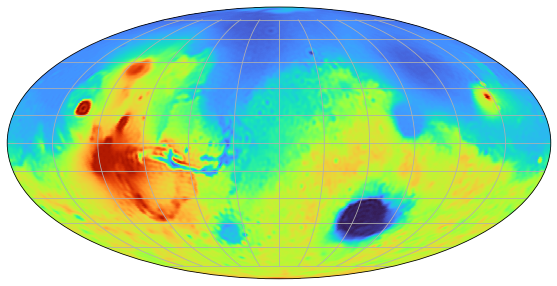

In [29]:
fig = plt.figure(figsize=(10, 5))
ax = fig.add_subplot(1, 1, 1, projection='mollweide')
ax.pcolormesh(Lon, Lat, sh_model().detach().cpu(), cmap=cmap)
# ax.set_title("Elevation map of mars")
ax.grid(True)
ax.set_xticklabels([])
ax.set_yticklabels([])
plt.show()

Not bad! Let us again plot the error:

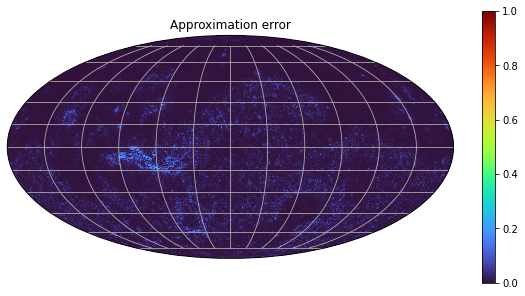

In [15]:
fig = plt.figure(figsize=(10, 5))
ax = fig.add_subplot(1, 1, 1, projection='mollweide')
img = ax.pcolormesh(Lon, Lat, (sh_model().detach() - signal).abs().cpu(), cmap=cmap, vmin=0, vmax=1)
ax.set_title("Approximation error")
ax.grid(True)
ax.set_xticklabels([])
ax.set_yticklabels([])
plt.colorbar(img, ax=ax)
plt.show()

## Conclusion

This concludes our introduction to `torch-harmonics`. If you are enjoying this library, make sure to cite us: